In [1]:
import os
import pandas as pd
import numpy as np
import random

import zipfile
from urllib import request

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torchvision import transforms

In [2]:
class NeuMF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, nums_hiddens,
                **kwargs):
        super(NeuMF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors) # GMF의 user
        self.Q = nn.Embedding(num_items, num_factors) # GMF의 item
        self.U = nn.Embedding(num_users, num_factors) # MLP의 user
        self.V = nn.Embedding(num_items, num_factors) # MLP의 item
        layers = []
        before_layer = num_factors*2
        for num_hiddens in nums_hiddens: 
            layers.append(nn.Linear(before_layer, num_hiddens, bias=True))
            layers.append(nn.ReLU())
            before_layer = num_hiddens
        self.mlp = nn.Sequential(*layers)
        self.prediction_layer = nn.Linear(before_layer*2, 1, bias=False)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id) # [2, 1, 10] (batch, 1, 10) 사이즈
        mlp = self.mlp(torch.cat((torch.squeeze(p_mlp, 1) , torch.squeeze(p_mlp, 1)), dim=1)) # (batch size, 20) -> (batch_size, 10)
        con_res = torch.cat((torch.squeeze(gmf), mlp), dim=1)
        pred = self.prediction_layer(con_res)
        return nn.Sigmoid()(pred) # sigmoid node는 1, 0~1사이의 값

In [3]:
class PRDataset(Dataset):
    """
    user id, 구매한 item id, 구매하지않은 item id
    """
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)]) 

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        # 해당 인덱스의 고객이 구매한 아이템을 제외한 전체 아이템
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

In [4]:
def download_ml100k():
    # download
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    savename = "ml-100k.zip"
    request.urlretrieve(url, savename)
    print('Complete!')
    # unzip
    file_name = os.path.join('./', savename)
    file_zip = zipfile.ZipFile(file_name)
    file_zip.extractall('./')
    file_zip.close()

def read_data_ml100k():
    """
    데이터를 다운받고, dataframe형태의 data, user id목록, itme id 목록 반환
    """
    if not os.path.isfile(os.path.join('./ml-100k/', 'u.data')):
        print('Download ...')
        download_ml100k()
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join('./ml-100k/', 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [5]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    """
    과정은 정확히 이해안되는데 user id, item id, score, 유저-아이템 행렬 반환
    explicit 일때는 유저 아이템 행렬
    implicit 일때는 key : (유저), val : (유저가 구매한 아이템의 리스트)로 하는 dict 
    """
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [6]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [7]:
batch_size = 50
df, num_users, num_items = read_data_ml100k()
train_data, test_data = split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_candidates = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")


train_iter = DataLoader(
    PRDataset(users_train, items_train, candidates, num_items), batch_size=batch_size)

test_iter = DataLoader(
    PRDataset(users_test, items_test, test_candidates, num_items), batch_size=batch_size)

C:\Users\jiwoo\AppData\Local\Temp\ipykernel_28460\2959204376.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df, num_users, num_items = read_data_ml100k()


In [8]:
batch = next(iter(train_iter)) # user, pos, neg
print(len(batch))

3


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuMF(num_factors=10, num_users=num_users, num_items=num_items, nums_hiddens=[10, 10, 10])
model = model.to(device)

In [10]:
class BPRLoss(nn.Module):
    def __init__(self, **kwargs):
        super(BPRLoss, self).__init__(**kwargs)
        self.sigmoid = nn.Sigmoid()

    def forward(self, positive, negative):
        distances = positive - negative
        loss = - torch.sum(torch.log(self.sigmoid(distances)))
        return loss

In [12]:
class ArrayDataset(Dataset):
  """
  for array input dataset
  """
  def __init__(self, user_array, item_array):
    self.user_array = user_array
    self.item_array = item_array

  def __len__(self):
    return len(self.user_array)

  def __getitem__(self, idx):
    return int(self.user_array[idx]), int(self.item_array[idx])

In [11]:
def hit_and_auc(rankedlist, test_matrix, k):
    """
    rankedlist : 
    test_matrix : test candidates(key = 유저, val = 유저가 구매한 아이템의 리스트인 dict)
    k : top k
    """
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k), auc

In [13]:
def evaluate_ranking(model, test_input, seq, candidates, num_users, num_items,
                     devices):
    """
    test input : test candidates(key = 유저, val = 유저가 구매한 아이템의 리스트인 dict)
    seq : None
    candidates : train_candidates 즉 train data의 candidates(key = 유저, val = 유저가 구매한 아이템의 리스트인 dict)
    num_users : user수
    num_items : item수
    """
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_users)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)])) # train data에서 user u가 구매하지 않은 아이템만 모으기
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([np.array(user_ids)])
        # if seq is not None:
        #     x.append(seq[user_ids, :])
        x.extend([np.array(item_ids)]) # x =  [user ids array, item ids array]

        test_data_iter = DataLoader(
            ArrayDataset(*x), shuffle=False, batch_size=20, drop_last=True) # test data iter는 batch size만큼 user ids, item ids 넘겨줌

        for index, values in enumerate(test_data_iter): # values : (user batch, item batch)
            x = [v.to(device) for v in values] # x = [cuda에 올린 item ids]
            scores.extend(model(*x).squeeze().tolist())
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

# evaluate_ranking(model, test_candidates, None, candidates, num_users, num_items, device)

In [14]:
lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'

loss_func = BPRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

In [15]:
from tqdm import tqdm
import glob
import os

train_epoch_loss = []
val_epoch_loss_lst = []
val_epoch_hit_lst = []
val_epoch_auc_lst = []
best_auc = 0
for epoch in tqdm(range(num_epochs)):
    train_iter_loss = []
    for i, values in enumerate(train_iter):
        p_pos = model(values[0].to(device), values[1].to(device)) 
        p_neg = model(values[0].to(device), values[2].to(device)) 
        loss = loss_func(p_pos, p_neg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_iter_loss.append(loss.detach().item())
        if i%500 == 0:
            print(f'{epoch} epoch {i}th train iter loss: {loss.detach().item()}')  
    train_epoch_loss.append(np.mean(train_iter_loss))
    print(f'{epoch} epoch ALL LOSS : ', np.mean(train_iter_loss))

    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        for i, values in enumerate(test_iter):
            p_pos = model(values[0].to(device), values[1].to(device)) 
            p_neg = model(values[0].to(device), values[2].to(device)) 
            loss = loss_func(p_pos, p_neg)
            val_epoch_loss += loss.detach().item()
            
        # 모든 val data 돌리고 나서 해당 에폭 loss, hit, auc append
        hit, auc = evaluate_ranking(model, test_candidates, None, candidates, num_users, num_items, device)
        val_epoch_hit_lst.append(hit)
        val_epoch_auc_lst.append(auc)
        val_epoch_loss /= len(test_iter)
        val_epoch_loss_lst.append(val_epoch_loss)

    if auc > best_auc:
        best_auc = auc
        print(f'New best model AUC : {best_auc}')
        if not os.path.exists('ncf_model'):
            os.mkdir('ncf_model')

        if os.path.exists('ncf_model/best.pth'):
            os.remove('ncf_model/best.pth')
            torch.save(model.state_dict(), 'ncf_model/best.pth')
            print('best model is saved!')

    

  0%|          | 0/10 [00:00<?, ?it/s]

0 epoch 0th train iter loss: 33.91693115234375
0 epoch 500th train iter loss: 34.65715408325195
0 epoch 1000th train iter loss: 34.48773956298828
0 epoch 1500th train iter loss: 29.469369888305664
0 epoch ALL LOSS :  33.02827084918556


 10%|█         | 1/10 [01:14<11:11, 74.64s/it]

New best model AUC : 0.5421340880645977
1 epoch 0th train iter loss: 26.31546401977539
1 epoch 500th train iter loss: 25.113170623779297
1 epoch 1000th train iter loss: 25.698665618896484
1 epoch 1500th train iter loss: 24.620702743530273
1 epoch ALL LOSS :  26.278117235565762


 20%|██        | 2/10 [02:24<09:35, 71.89s/it]

New best model AUC : 0.6004511784592712
2 epoch 0th train iter loss: 25.77259635925293
2 epoch 500th train iter loss: 26.52109718322754
2 epoch 1000th train iter loss: 22.930421829223633
2 epoch 1500th train iter loss: 24.372390747070312
2 epoch ALL LOSS :  24.45318482838774


 30%|███       | 3/10 [03:36<08:22, 71.78s/it]

New best model AUC : 0.6374743377191534
3 epoch 0th train iter loss: 23.953472137451172
3 epoch 500th train iter loss: 25.29408836364746
3 epoch 1000th train iter loss: 24.678863525390625
3 epoch 1500th train iter loss: 24.39584732055664
3 epoch ALL LOSS :  23.673089505565155


 40%|████      | 4/10 [04:46<07:06, 71.07s/it]

New best model AUC : 0.6551231934964316
4 epoch 0th train iter loss: 24.000459671020508
4 epoch 500th train iter loss: 23.724458694458008
4 epoch 1000th train iter loss: 24.86843490600586
4 epoch 1500th train iter loss: 25.480470657348633
4 epoch ALL LOSS :  23.030886936620796


 50%|█████     | 5/10 [05:56<05:54, 70.90s/it]

New best model AUC : 0.6682949536452768
5 epoch 0th train iter loss: 21.908424377441406
5 epoch 500th train iter loss: 22.87909507751465
5 epoch 1000th train iter loss: 24.182701110839844
5 epoch 1500th train iter loss: 24.608200073242188
5 epoch ALL LOSS :  22.73684820818492


 60%|██████    | 6/10 [07:06<04:42, 70.50s/it]

New best model AUC : 0.6817405883344497
6 epoch 0th train iter loss: 20.8261661529541
6 epoch 500th train iter loss: 22.16923713684082
6 epoch 1000th train iter loss: 22.958641052246094
6 epoch 1500th train iter loss: 22.12628173828125
6 epoch ALL LOSS :  22.487463559199774


 70%|███████   | 7/10 [08:15<03:30, 70.14s/it]

7 epoch 0th train iter loss: 20.925212860107422
7 epoch 500th train iter loss: 23.09656524658203
7 epoch 1000th train iter loss: 24.402027130126953
7 epoch 1500th train iter loss: 23.973861694335938
7 epoch ALL LOSS :  22.324868025861523


 80%|████████  | 8/10 [09:25<02:19, 69.82s/it]

New best model AUC : 0.6833002742540302
8 epoch 0th train iter loss: 21.694698333740234
8 epoch 500th train iter loss: 22.052579879760742
8 epoch 1000th train iter loss: 24.79398536682129
8 epoch 1500th train iter loss: 23.468334197998047
8 epoch ALL LOSS :  22.11294964440054


 90%|█████████ | 9/10 [10:36<01:10, 70.31s/it]

9 epoch 0th train iter loss: 21.618043899536133
9 epoch 500th train iter loss: 23.52237319946289
9 epoch 1000th train iter loss: 22.40962028503418
9 epoch 1500th train iter loss: 22.45237922668457
9 epoch ALL LOSS :  22.036433266943806


100%|██████████| 10/10 [11:47<00:00, 70.77s/it]

New best model AUC : 0.6891893976027892


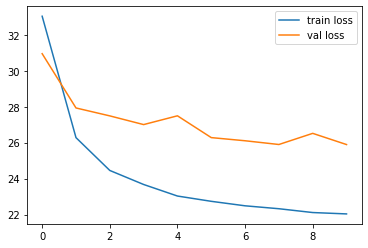

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_epoch_loss, label='train loss')
plt.plot(val_epoch_loss_lst, label='val loss')
plt.legend()

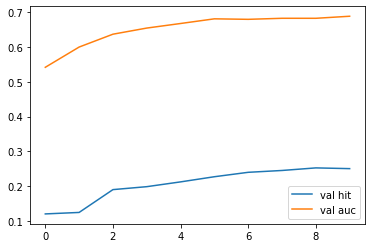

In [18]:
plt.plot(val_epoch_hit_lst, label='val hit')
plt.plot(val_epoch_auc_lst, label='val auc')
plt.legend()